In [11]:
from configs import lr_configs

In [3]:
lr_config.SGD_config['optimizer']

{'lr': 0.1, 'momentum': 0.9, 'nesterov': True, 'weight_decay': 0.0005}

In [9]:
def gg(lr, momentum, weight_decay, nesterov):
    print(lr, momentum, nesterov, weight_decay)

In [10]:
gg(**getattr(lr_config, 'SGD_config')['optimizer'])

0.1 0.9 True 0.0005


In [7]:
getattr(lr_config, 'SGD_config')

{'optimizer': {'lr': 0.1,
  'momentum': 0.9,
  'nesterov': True,
  'weight_decay': 0.0005},
 'scheduler': {'steps': [60, 120, 160], 'gamma': 0.2}}

In [13]:
lr_config = getattr(lr_configs, 'SGD_config')

len(lr_config['scheduler'])

2

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable

In [72]:
class LeNet_passport(nn.Module):

    def __init__(self, in_channels=1, num_classes=10):
        super(LeNet_passport, self).__init__()
        self.count = 0

        self.net1 = nn.Conv2d(in_channels, 6, kernel_size=5, padding=2)

        self.passport_gamma = torch.randn((1, 1, 28, 28), device='cuda') 
        self.passport_beta = torch.randn((1, 1, 28, 28), device='cuda')
    
        self.encoder = nn.Sequential(nn.Flatten(), 
                                nn.Linear(6 * 28 * 28, 10), 
                                # nn.Linear(128, 6 * 28 * 28)
                                )

        self.net2 = nn.Sequential(nn.ReLU(),
                    nn.AvgPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
                    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
                    nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
                    nn.Linear(120, 84), nn.ReLU(), nn.Linear(84, num_classes))
        
        def init_weights(m):
            if type(m) == nn.Linear:
                # nn.init.normal_(m.weight, std=0.01)
                # nn.init.xavier_uniform_(m.weight, gain=1)
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

        self.net1.apply(init_weights)
        self.net2.apply(init_weights)


    def forward(self, X):
        y = self.net1(X)

        # if self.count > 200:
        #     gamma = self.encoder(self.net1(self.passport_gamma)).mean()
        #     beta = self.encoder(self.net1(self.passport_beta)).mean()
        #     # print(gamma, beta)

        # else:
            # if self.count % 10 < 4:
            #     gamma = self.encoder(self.net1(self.passport_gamma)).mean().detach()
            #     beta = self.encoder(self.net1(self.passport_beta)).mean().detach()
            
            # elif self.count % 10 < 7:
            #     gamma = self.encoder(self.net1(self.passport_gamma).detach()).mean()
            #     beta = self.encoder(self.net1(self.passport_beta).detach()).mean()
            
            # else:
            #     gamma = self.encoder(self.net1(self.passport_gamma)).mean()
            #     beta = self.encoder(self.net1(self.passport_beta)).mean()

            # if self.count % 10 < 5:
            #     gamma = self.encoder(self.net1(self.passport_gamma)).mean().detach()
            #     beta = self.encoder(self.net1(self.passport_beta)).mean().detach()
            
            # else:
            #     gamma = self.encoder(self.net1(self.passport_gamma).detach()).mean()
            #     beta = self.encoder(self.net1(self.passport_beta).detach()).mean()

        gamma = self.encoder(self.net1(self.passport_gamma).detach()).mean()
        beta = self.encoder(self.net1(self.passport_beta).detach()).mean()

        y.mul_(gamma).add_(beta)
        return self.net2(y)

In [73]:
X = torch.ones([2, 1, 28, 28]).cuda()
net = LeNet_passport().cuda()

In [76]:
optimizer = torch.optim.SGD([
    {'params': net.encoder.parameters(), 'lr': 0.001},
    {'params': net.net1.parameters()},
    {'params': net.net2.parameters()},
], lr=0.01)

In [77]:
for param_group in optimizer.param_groups:
    print(param_group['lr'])

0.001
0.01
0.01


In [65]:
y1 = net(X)

In [1]:
import errno
import os
import sys
from collections import defaultdict

import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets.cifar import CIFAR10, CIFAR100
from torchvision.datasets import FashionMNIST, MNIST
from torchvision.datasets.folder import pil_loader, make_dataset, IMG_EXTENSIONS, ImageFolder
from torchvision.transforms import transforms


In [9]:
ds = 'mnist'
# MNIST
mean, std = (0.1307,), (0.3081,)

# mean, std = (0.286,), (0.352),

train_trans = transforms.Compose([
    # transforms.RandomCrop(28, padding=2),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
test_trains = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
train_dataset = MNIST(root=f"./data/{ds}",
                            train=True,
                            transform=train_trans,
                            download=True)
test_dataset = MNIST(root=f"./data/{ds}",
                            train=False,
                            transform=test_trains,
                            download=True)
args = {"K":5, "batch_size": 128}
splits = []
size = len(train_dataset) // args['K']
for _ in range(args['K'] - 1):
    splits.append(size)
splits.append(len(train_dataset) - size * (args['K'] - 1))

train_datasets = torch.utils.data.random_split(train_dataset, splits)

In [14]:
loaders = [DataLoader(train_dataset, args['batch_size'], shuffle=True,
                            num_workers=0) for train_dataset in train_datasets]

In [12]:
import matplotlib.pyplot as plt
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5, cmap='Blues'):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # Tensor Image
            ax.imshow(img.numpy(), cmap=cmap)
        else:
            # PIL Image
            ax.imshow(img, cmap=cmap)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes


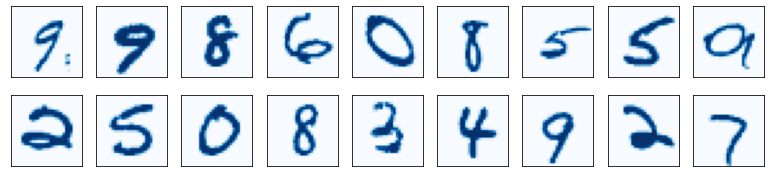

In [19]:
for X, y in loaders[0]:
    show_images(X[:18].reshape(18, 28, 28), 2, 9)
    break

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

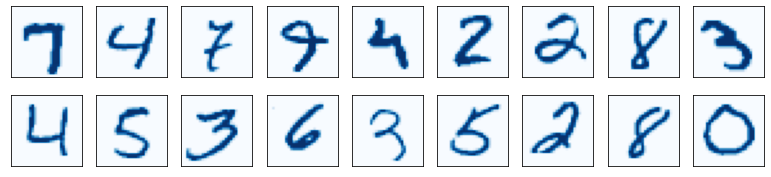

In [23]:

X, y = next(iter(loaders[0]))
show_images(X[:18].reshape(18, 28, 28), 2, 9)


In [37]:
train_iters = list(map(lambda loader: iter(loader), loaders))

In [1]:
from models.lenet import LeNet, LeNet_passport
import torch

In [2]:
model = LeNet()

In [3]:
optimizer = torch.optim.SGD([
    {'params': model.net1.parameters()},
    {'params': model.net2.parameters()},
], lr=0.1)

In [5]:
for param_group in optimizer.param_groups:
    for p in param_group['params']:
        print(p)

Parameter containing:
tensor([[[[ 0.1846,  0.0735, -0.1361, -0.0087, -0.0789],
          [ 0.0067, -0.1020,  0.1307,  0.0826,  0.1237],
          [-0.1755, -0.0997,  0.0581,  0.1714, -0.0906],
          [ 0.0148,  0.1095,  0.1605,  0.0975, -0.1045],
          [-0.0677, -0.0276, -0.1321,  0.1836,  0.0630]]],


        [[[ 0.0273, -0.1859,  0.1467,  0.0595,  0.1933],
          [ 0.1428, -0.1865, -0.0719, -0.0188, -0.0324],
          [-0.1623,  0.0599, -0.0272,  0.0427, -0.1243],
          [-0.0906,  0.0801,  0.1549,  0.1644, -0.1137],
          [-0.0895,  0.0526, -0.0218, -0.1288,  0.1931]]],


        [[[-0.0556, -0.0703,  0.1214, -0.0200, -0.1073],
          [-0.0087, -0.0814, -0.1192, -0.1052,  0.0140],
          [ 0.1013,  0.0443, -0.1128,  0.0638, -0.1844],
          [ 0.1934,  0.0468, -0.0315, -0.0739,  0.1603],
          [ 0.0334, -0.1241,  0.1733,  0.0045,  0.0204]]],


        [[[ 0.1008, -0.1467, -0.1782, -0.0441, -0.1103],
          [-0.1209, -0.1918,  0.1475, -0.0493, -0.0420

In [6]:
X = torch.ones(2, 1, 28, 28)
model(X)

tensor([[ 0.1959,  0.2212,  0.2907, -0.1220,  0.0395, -0.1766,  0.0168, -0.1835,
         -0.0150, -0.0025],
        [ 0.1959,  0.2212,  0.2907, -0.1220,  0.0395, -0.1766,  0.0168, -0.1835,
         -0.0150, -0.0025]], grad_fn=<AddmmBackward>)

In [2]:
p = iter(gg())

In [16]:
next(p)

0

In [17]:
next(p)

2

GG
